In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat 

PROJECT_ROOT_DIR = "./"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img")
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
data = loadmat(os.path.join(DATA_PATH, 'ex4data1.mat'))

#data and nn params
y = data['y'].ravel() # (5000, 1) --> (5000,)
X = data['X']
m = len(y)
input_size = X.shape[1]
num_labels = 10
hidden_size = 25
learning_rate = 1

#one hot encoding
y = (y - 1)
y_onehot = np.zeros((m, num_labels))  # 5000 x 10
for i in range(m):
    y_onehot[i][y[i]] = 1

In [4]:
#load weights pre trained
weights = loadmat(os.path.join(DATA_PATH, "ex4weights.mat"))
theta1, theta2 = weights['Theta1'], weights['Theta2']
# Theta1 es de dimensión 25 x 401
# Theta2 es de dimensión 10 x 26

In [5]:
#funcion sigmoide
def sigmoid(z):
    return 1/(1+np.exp(-z))

#derivada de la funcion sigmoide
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))


In [6]:
#propagacion hacia delante de la red
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    a1 = np.hstack([np.ones([m, 1]), X])
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    z3 = np.dot(a2, theta2.T)
    h = sigmoid(z3)
    return a1, z2, a2, z3, h

In [7]:
#computa el coste y el gradiente de la red neuronal, propagando hacia atras la red
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg = 0):
    #desenredar los parametros pasados como un array en params_rn
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)] ,(num_ocultas , (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):] ,(num_etiquetas, (num_ocultas + 1)))
    m = X.shape[0]
    
    #forward_prop params
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    #calculo del coste
    cost = 0
    
    for i in range(m):
        #primer termino
        primer_termino = np.dot(-y[i,:], np.log(h[i,:]))
        #segundo termino
        segundo_termino = np.dot(1 - y[i,:], np.log(1 - h[i,:]))

        cost += np.sum(primer_termino - segundo_termino)
        
    cost = cost / m
    
    #con regularizacion
    if reg != 0:
        cost += reg/(2*m) * (np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2)))
    
    
    #backpropagation
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    for t in range(m):
        a1t = a1[t, :] # (1, 401)
        a2t = a2[t, :] # (1, 26)
        ht = h[t, :] # (1, 10)
        yt = y[t] # (1, 10)
        d3t = ht - yt # (1, 10)
        d2t = np.dot(theta2.T, d3t) * (a2t * (1 - a2t)) # (1, 26)
        delta1 = delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        delta2 = delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    #con regularizacion
    if reg != 0:
        delta1[:, 1:] = delta1[:, 1:] + (theta1[:, 1:] * reg) / m
        delta2[:, 1:] = delta2[:, 1:] + (theta2[:, 1:] * reg) / m
    
    #gradiente computado de cada capa
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return cost, grad

In [8]:
#devuelve una matriz aleatoria de (L_in, L_out + 1) que se encuentra entre el rango de (-e_ini, e_ini)
def pesosAleatorios(L_in, L_out):
    e_ini = 0.12
    params = np.random.rand(L_in, L_out + 1)
    params = ((e_ini - (-e_ini)) * params) - e_ini #Regularizar entre (-e_ini, e_ini)
    return params

In [9]:
#prueba sin regularizacion -> 0.287
params = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
backprop(params, X.shape[1], hidden_size, num_labels, X, y_onehot)

(0.2876291651613188,
 array([ 6.18712766e-05,  0.00000000e+00,  0.00000000e+00, ...,
         9.66104721e-05, -7.57736846e-04,  7.73329872e-04]))

In [10]:
#prueba con regularizacion -> 0.387
params = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
backprop(params, X.shape[1], hidden_size, num_labels, X, y_onehot, learning_rate)

(0.38376985909092354,
 array([ 6.18712766e-05, -2.11248326e-12,  4.38829369e-13, ...,
         4.70513145e-05, -5.01718610e-04,  5.07825789e-04]))

In [11]:
#comprobar que el calculo del gradiente de la funcion backprop esta bien
%run checkNNGradients.py
checkNNGradients(backprop, learning_rate)

array([ 5.27760891e-11,  7.32719441e-13,  8.82988127e-12,  7.53046930e-12,
       -6.52669724e-11,  4.33014735e-12, -1.60946811e-11, -4.70333078e-11,
       -8.85581053e-11,  5.59484403e-12, -4.34998149e-11, -1.24423472e-10,
       -2.17855040e-11,  4.35645964e-12, -9.22964483e-12, -2.43030734e-11,
        2.15736456e-11,  2.27623476e-13,  7.55696200e-12,  2.84505197e-11,
        6.03759820e-11,  1.83081883e-11,  4.06510936e-12,  5.29278010e-12,
        1.81106657e-11,  1.78381754e-11,  7.15513759e-11,  1.63749014e-11,
        7.86468113e-12,  1.17110488e-11,  1.64833286e-11,  1.95246597e-11,
        7.32915395e-11,  1.66865410e-11,  8.55090998e-12,  1.63125624e-11,
        1.56829272e-11,  1.99839589e-11])

In [12]:
from scipy.optimize import minimize

#generamos los theta iniciales con la funcion de pesos aletorios
theta1_rand = pesosAleatorios(hidden_size, X.shape[1])
theta2_rand = pesosAleatorios(num_labels, hidden_size)

params = np.concatenate((np.ravel(theta1_rand), np.ravel(theta2_rand)))

#uso de la funcion minimize con un maximo de itereciones de 70
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
                method='TNC', jac=True, options={'maxiter': 70})
fmin

     fun: 0.5668238641568152
     jac: array([ 2.18235439e-05, -1.62473842e-05,  6.32874736e-06, ...,
        1.54005161e-03,  1.51659435e-03,  1.35039853e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 70
     nit: 13
  status: 3
 success: False
       x: array([ 0.03463265, -0.08123692,  0.03164374, ..., -0.59737636,
       -1.60827526,  0.58811144])

In [13]:
#con la funcion de coste minimizada usamos los nuevos theta ya entrenados
theta1_train = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2_train = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

#propagamos hacia delante los datos con los thetas entrenados para que nos den la salida de la red 
a1, z2, a2, z3, h = forward_propagate(X, theta1_train, theta2_train)
neural_pred = h.argmax(axis=1)+1

In [14]:
from sklearn.metrics import confusion_matrix, f1_score
def scores(y, neural_pred, show = True):
    f1 = f1_score(y, neural_pred, average='weighted')
    accuracy = np.mean(neural_pred == y[:])
    print("f1_score:", f1)
    print("accuracy:", accuracy)
    if show:
        plt.figure(figsize = (10,10))
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.imshow(confusion_matrix(y, neural_pred), cmap='viridis')
        plt.show()
    return f1, accuracy

f1_score: 0.9368333700552514
accuracy: 0.937


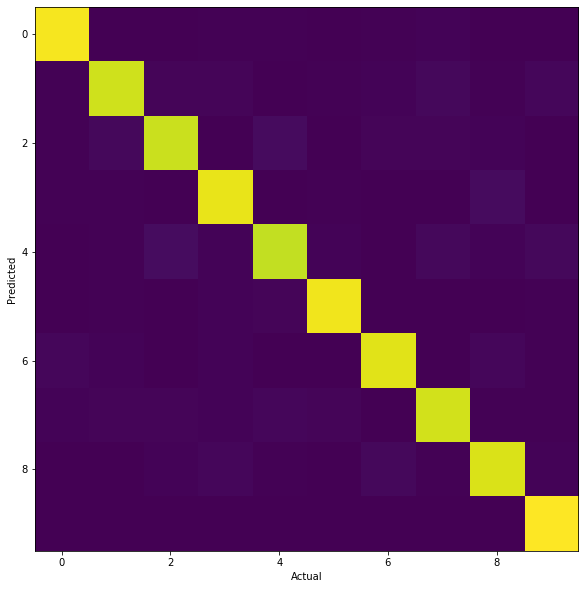

(0.9368333700552514, 0.937)

In [15]:
#la precicision con 70 iteraciones y un lambda = 1 esta en torno al 94%
y = data['y']
scores(y, neural_pred)

In [16]:
def train_nn(X , y, input_size, num_labels, hidden_size, learning_rate):
    #one hot encoding
    y = y.ravel()
    y = (y - 1)
    y_onehot = np.zeros((m, num_labels))  # 5000 x 10
    for i in range(m):
        y_onehot[i][y[i]] = 1
    
    theta1_rand = pesosAleatorios(hidden_size, X.shape[1])
    theta2_rand = pesosAleatorios(num_labels, hidden_size)

    params = np.concatenate((np.ravel(theta1_rand), np.ravel(theta2_rand)))

    fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
                    method='TNC', jac=True, options={'maxiter': 70})
    
    theta1_train = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2_train = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

    a1, z2, a2, z3, h = forward_propagate(X, theta1_train, theta2_train)
    neural_pred = h.argmax(axis=1)+1
    y = data['y']
    f1, accuracy = scores(y, neural_pred, show = True)
    return f1, accuracy

f1_score: 0.9234294414161747
accuracy: 0.9236


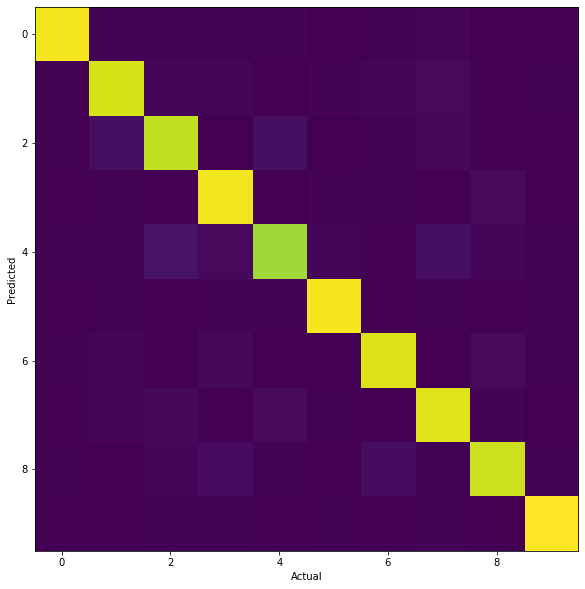

(0.9234294414161747, 0.9236)

In [17]:
learning_rate = 0.75
train_nn(X , y, input_size, num_labels, hidden_size, learning_rate)